In [1]:
# import libraries
import csv
import math
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

master=pd.read_excel('C:/Users/liuz2/Documents/Projects/SuicideRates/WHO_all.xlsx', \
    sheet_name='Sheet1', usecols='A:AM')    
master=master.rename(columns={'Countries':'country'})
# Remove rows that we don't have population or GDP data on
master=master[~master['country'].isin(['Rodrigues','Reunion','Occupied Palestinian Territory',\
    'Netherlands Antilles','Montserrat','Mayotte','Martinique','Anguilla','TFYR Macedonia',\
    'Saint Pierre and Miquelon','Falkland Islands (Malvinas)','French Guiana','Guadeloupe',\
    'Total reporting countries'])]
master['country']=np.where(master['country']=='Bahamas', 'Bahamas, The', 
    np.where(master['country']=='Egypt', 'Egypt, Arab Rep.',
    np.where(master['country']=='Hong Kong SAR', 'Hong Kong SAR, China',
    np.where(master['country']=='Iran (Islamic Rep of)', 'Iran, Islamic Rep.',
    np.where(master['country']=='Kyrgyzstan', 'Kyrgyz Republic', 
    np.where(master['country']=='Macau', 'Macao SAR, China', 
    np.where(master['country']=='Republic of Moldova','Moldova',
    np.where(master['country']=='Republic of Korea', 'Korea, Rep.',
    np.where(master['country']=='Saint Kitts and Nevis', 'St. Kitts and Nevis',
    np.where(master['country']=='Saint Lucia', 'St. Lucia',
    np.where(master['country']=='Saint Vincent and Grenadines', 'St. Vincent and the Grenadines',
    np.where(master['country']=='Slovakia','Slovak Republic', 
    np.where(master['country']=='United States of America','United States',
    np.where(master['country']=='Venezuela (Bolivarian Republic of)','Venezuela, RB',
    np.where(master['country']=='Virgin Islands (USA)','Virgin Islands (U.S.)',   
    master['country'])))))))))))))))
# Transpose into long format
master=pd.melt(master, id_vars=['country'], var_name='year', value_name='suicides_no')
master['year']=master['year'].astype('int64')
master['suicides_no'] = pd.to_numeric(master['suicides_no'],errors='coerce')

# Unemployment Rate Data
uem=pd.read_csv('C:/Users/liuz2/Documents/Projects/SuicideRates/UEM.csv')
uem=uem[uem['Indicator Code']=='SL.UEM.TOTL.NE.ZS']
country=uem[['Country Name', 'Country Code']]
country.columns=['country','iso3c']
not_country=["ARB","CEB", "CSS","EAP","EAR","EAS","ECA","ECS","EMU","EUU","FCS","HIC","HPC","IBD","IBT","IDA","IDB",
"IDX","INX","LAC","LCN","LDC","LIC","LMC","LMY","LTE","MEA","MIC","MNA","NAC","OED","OSS","PRE","PSS","PST","SAS","SSA","SSF","SST","TEA","TEC","TLA","TMN","TSA","TSS","UMC","WLD"]
country=country.assign(not_country=lambda x: x['iso3c'].isin(not_country))
def makelong(dat,varname):
    output_dat=dat.drop(['Indicator Name','Indicator Code','Country Name'],axis=1)
    output_dat=pd.melt(output_dat, id_vars=['Country Code'], var_name='year', value_name=varname)
    output_dat.columns=['iso3c','year',varname]
    return(output_dat)
uem=makelong(uem, 'Unemployment')
uem['year']=uem['year'].astype('int64')
master=pd.merge(master, country, how='left', on=['country'])
master=pd.merge(master, uem, how='left', left_on=['iso3c','year'], right_on=['iso3c','year'])

#Population
popu=pd.read_csv('C:/Users/liuz2/Documents/Projects/World Bank/Population/API_SP.POP.TOTL_DS2_en_csv_v2_10576638.csv', encoding="utf-8", skiprows=4)
popu=popu.drop(['Unnamed: 63','2018','Indicator Name','Indicator Code','Country Name'],axis=1)
populong=pd.melt(popu, id_vars=['Country Code'], var_name='year', value_name='pop')
populong.columns=['iso3c','year','population']
populong['year']=populong['year'].astype('int64')
master=pd.merge(master, populong, how='left', left_on=['iso3c','year'], right_on=['iso3c','year'])
del popu
#GDP
gdp=pd.read_csv('C:/Users/liuz2/Documents/Projects/World Bank/GDP/GDP-Per-Capita-PPP-Constant-2011-International/API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_41408.csv',\
     encoding='utf-8', skiprows=4, nrows=264)
gdp=gdp.drop(['Indicator Name', 'Indicator Code', 'Country Name', 'Unnamed: 63'], axis=1)
gdplong=pd.melt(gdp, id_vars=['Country Code'], var_name='year', value_name='gdp')
gdplong.columns=['iso3c','year','gdp']
gdplong.year=gdplong.year.str.slice(0,4)
gdplong['gdp']=pd.to_numeric(gdplong['gdp'], errors='coerce') 
gdplong['loggdp']=np.log(gdplong['gdp'])
gdplong['year']=gdplong['year'].astype('int64')
master=pd.merge(master,gdplong, how='left', left_on=['iso3c','year'], right_on=['iso3c','year'])
del gdp
# Gini
gini=pd.read_csv('C:/Users/liuz2/Documents/Projects/World Bank/Gini/API_SI.POV.GINI_DS2_en_csv_v2_126296.csv', encoding='utf-8', nrows=264)
gini=gini.drop(['Indicator Name','Indicator Code','Country Name'], axis=1)
ginilong=pd.melt(gini, id_vars=['Country Code'], var_name='year', value_name='gini')
ginilong.columns=['iso3c','year','gini']
ginilong['gini']=pd.to_numeric(ginilong['gini'], errors='coerce') 
ginilong['year']=ginilong['year'].astype('int64')
master=pd.merge(master,ginilong, how='left', left_on=['iso3c','year'], right_on=['iso3c','year'])
del gini
#Consumer Price Index
cpi=pd.read_csv('C:/Users/liuz2/Documents/Projects/World Bank/ConsumerPriceIndex/API_FP.CPI.TOTL_DS2_en_csv_v2_315921.csv', \
    encoding='utf-8', skiprows=4, nrows=264)
cpi=cpi.drop(['Indicator Name','Indicator Code','Country Name', 'Unnamed: 63'], axis=1)
cpilong=pd.melt(cpi, id_vars=['Country Code'], var_name='year', value_name='cpi')
cpilong.columns=['iso3c','year','cpi']
cpilong['cpi']=pd.to_numeric(cpilong['cpi'], errors='coerce') 
cpilong['year']=cpilong['year'].astype('int64')
master=pd.merge(master,cpilong, how='left', left_on=['iso3c','year'], right_on=['iso3c','year'])
del cpi

master['SR']=master['suicides_no']/(master['population']/100000)
SR_country=master[(master['suicides_no']>=0) & (master['population']>0)]
SR_country['Top']=np.where(SR_country['country'].isin(['Lithuania', 'Hungary']), SR_country['country'], 'Other')

c:\Users\liuz2\Documents\Projects\SuicideRates\SR-Story.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  cpilong['year']=cpilong['year'].astype('int64')


# Does the economy affect suicide rates?
## What is this?
 An exploration of suicide data from 1980 to 2016 in 128 countries reported in the WHO Mortality Database
 and how the reported suicide rates change with the economy
## Which countries have the higest suicide rates
 Two countries stands out on top of the chart: Hungary and Lithuania

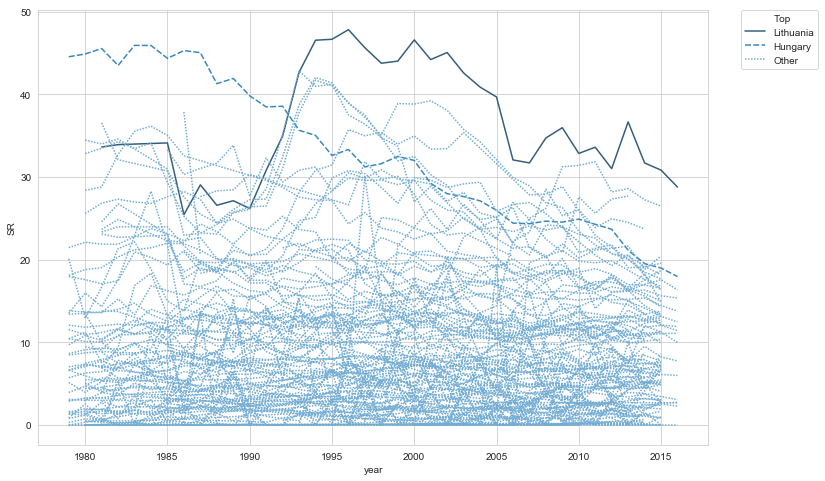

In [2]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=SR_country, x='year', y='SR', estimator=None, units='country', \
    hue='Top', hue_order=['Lithuania', 'Hungary', 'Other'], \
    style='Top', style_order=['Lithuania', 'Hungary', 'Other'], \
    palette=sns.color_palette('Blues_d', 3))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [3]:
#Check Suicide of UK, France, Germany for Ying
'''
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=SR_country[SR_country['country'].isin(['France','Germany','United Kingdom','Italy','Spain','Belgium'])], \
    x='year', y='SR', estimator=None, units='country', \
    hue='country', style='country')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.lineplot(data=SR_country[SR_country['country'].isin(['Belgium'])], x='year', y='SR')
'''

"\nsns.set_style('darkgrid')\nplt.figure(figsize=(12,8))\nsns.lineplot(data=SR_country[SR_country['country'].isin(['France','Germany','United Kingdom','Italy','Spain','Belgium'])],     x='year', y='SR', estimator=None, units='country',     hue='country', style='country')\nplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)\nsns.lineplot(data=SR_country[SR_country['country'].isin(['Belgium'])], x='year', y='SR')\n"

 To find out what other countries have high suicide rates (SR), we tabulate the top 5 countries with the highst SR
 from 1980 to 2016 and then counted how many times each country appears.

In [4]:
top5=dict() #Record the rank of the top 5 countries by year
top5_ctr=dict() #Tabulate the counts for each country
tmp=list()
for year in range(1980,2017):
    top5[year]=list(SR_country[SR_country['year']==year][['country', 'SR']].sort_values(by=['SR'],ascending=False).head(5)['country'])
    for country in top5[year]:
        SR=SR_country[(SR_country['year']==year) & (SR_country['country']==country)][['SR']].iloc[0,0]
        tmp.append([country, year, SR])
        if country in top5_ctr.keys():
            top5_ctr[country]=top5_ctr[country]+1
        else:
            top5_ctr[country]=1
top5_data=pd.DataFrame(tmp, columns=['country','year','SR'])
del tmp, SR
top5_count=pd.DataFrame(sorted(top5_ctr.items(), key=lambda kv: kv[1], reverse=True), columns=['country','count'])


 Hungary ranked the highest in SR from 1980 to 1992. In 1993, Latvia rose to the top (SR=42.87), with Lithuania as a close second (SR=42.69).
 Starting from 1994 onwards, Lithuania remained on the top of the chart.

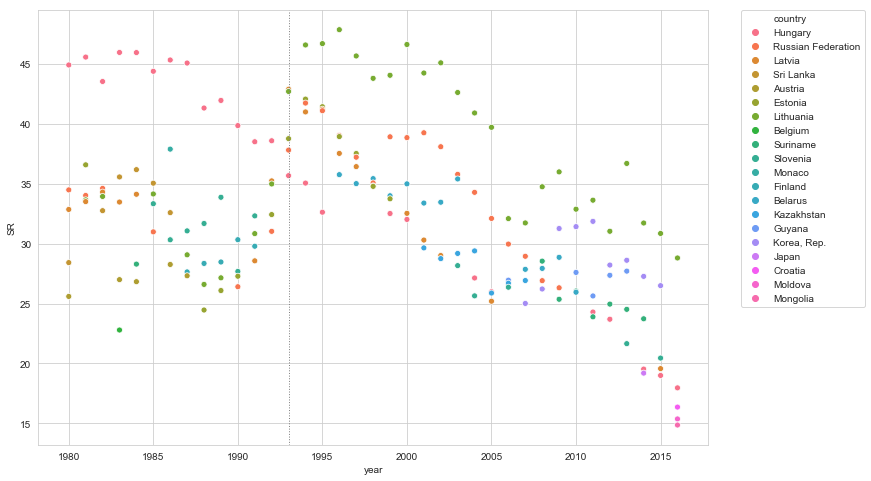

In [5]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=top5_data, x='year', y='SR', estimator=None, units='country', hue='country')
plt.axvline(x=1993, linewidth=1, linestyle=':', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


 The countries that frequently rank in the top 5 include (but are not limited to) Lithuania, Russia, Hungary, Latvia,
 Belarus, Slovenia, and Estonia. Only two East Esian Countries made it to the list -- Korea and Japan.

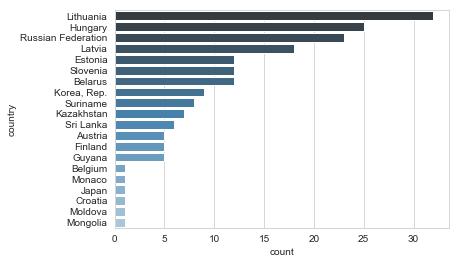

In [6]:
sns.barplot(data=top5_count, x='count', y='country', orient='h', palette="Blues_d")
#print(sorted(top5_ctr.items(), key=lambda kv: kv[1], reverse=True))


## Suicide Rates and Economy
 We wanted to determine whether changes in economic growth impacted national suicide rates.
 We hypothesize that suicide rates will be negatively correlated with economic growth, that is, national suicide rates
 decrease as an economy imporoves and vice versa.
 Four economic indices were selected: GDP (per capita PPP constant in 2011 international $), unemployment rate, consumer price index, and Gini coefficient.

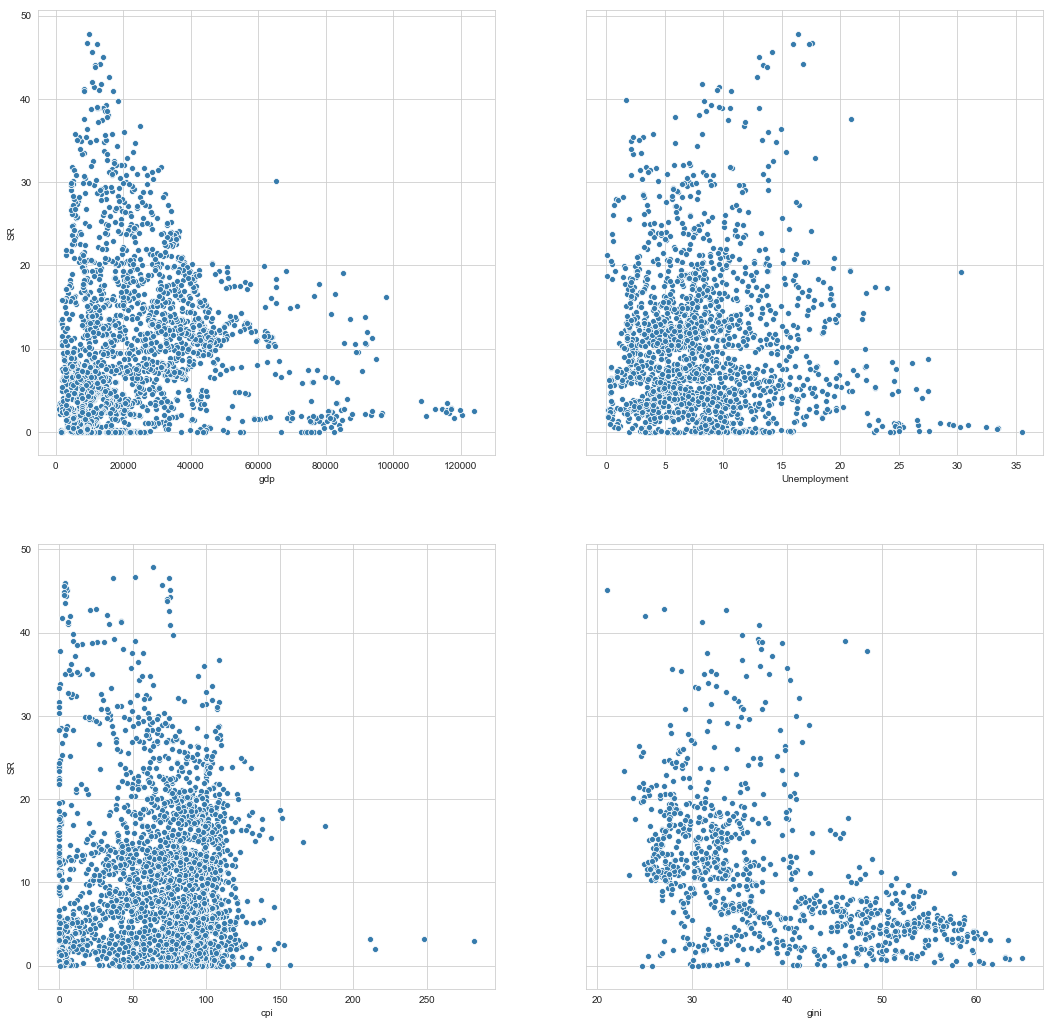

In [7]:
f, axes=plt.subplots(2,2, figsize=(18,18), sharey=True)
sns.set_style('white')
col1=sns.color_palette('Blues_d', 6)[2]
sns.scatterplot(data=SR_country, x='gdp', y='SR', estimator=None, units='country', color=col1, ax=axes[0,0])
sns.scatterplot(data=SR_country, x='Unemployment', y='SR', estimator=None, units='country', color=col1, ax=axes[0,1])
sns.scatterplot(data=SR_country, x='cpi', y='SR', estimator=None, units='country', color=col1, ax=axes[1,0])
sns.scatterplot(data=SR_country, x='gini', y='SR', estimator=None, units='country', color=col1, ax=axes[1,1])


 When plotted against suicide rates, neither GDP nor unemployment rates show any apparent correlation to suicide rates (r=0.05 for GDP
 and r=-0.03 for unemloyment). Curiously, Gini coefficient is the only economic index that shows a semi-moderate correlation with suicide rates (r=-0.49).
 However, the association appears to be counter-intuitive: as the Gini coefficient increases (that is, as economic inequality increases),
 suicide rates decreases.
 Before too-rapidly attempting to make sense of this correlation, we reviewed existing literature and found a mixed track record of Gini
 coefficient and suicide rates. Some studies find higher inequality correlate with higher rates of suicide, while other studies find higher inequality
 correlate with lower rates of suicide. Sometimes, there is no correlation. Perhaps, there is no single economic indicator for all countries.
 We need to examine impact of economic changes on suicide rates in individual cases.
## Suicide Rates and Crises
 When viewing the data of all countries across all years, we see a lot of noise: as such, we selected several crises with a great impact
 on countries’ economies, to confirm whether suicide rates changes in response to these economic transformations. We examined a political
 crisis (the dissolution of the Soviet Union) and an economic crisis (the 1997 Asian financial crisis) to see if any economic indicators
 were associated with suicide-rate changes.
### The dissolution of the Soviet Union
 To study the effect of the dissolution of the Soviet Union on suicide rates, we analyzed the 15 countries composing the USSR .
 Seven of the fifteen countries (Ukraine, Belarus, Lithuania, Latvia, Kazakhstan, Estonia, Russia) display very similar patterns
 in SR across the years following the dissolution of the USSR. Specifically, during 1991 to 1995, the five years including and immediately
 following the dissolution, a similar jump in SR can be seen in all seven countries. Interestingly, in the other eight countries,
 no such jump in SR can be found across that time period.

In [8]:
USSR=['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia','Kazakhstan',\
    'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russian Federation',\
    'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
USSR1=['Belarus', 'Estonia', 'Kazakhstan', 'Latvia', 'Lithuania', 'Russian Federation','Ukraine']
USSR2=['Armenia', 'Azerbaijan', 'Georgia', 'Kyrgyz Republic', 'Moldova', 'Tajikistan', 'Turkmenistan','Uzbekistan']
USSR_dat=SR_country[SR_country['country'].isin(USSR)]
USSR_dat1=SR_country[SR_country['country'].isin(USSR1)]
USSR_dat2=SR_country[SR_country['country'].isin(USSR2)]


#### The USSR Cohort 1: Ukraine, Belarus, Lithuania, Latvia, Kazakhstan, Estonia, Russia

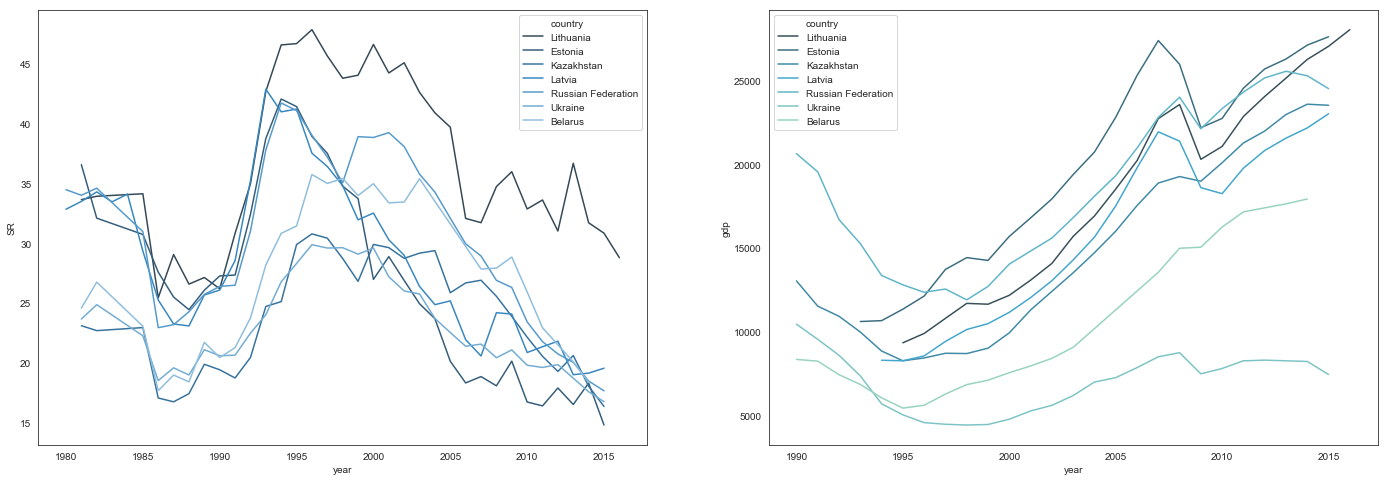

In [9]:
f, axes=plt.subplots(1,2, figsize=(24,8))
sns.set_style('whitegrid')
sns.lineplot(data=USSR_dat1, x='year', y='SR', estimator=None, units='country', hue='country', palette=sns.color_palette('Blues_d', 7), ax=axes[0])
sns.lineplot(data=USSR_dat1, x='year', y='gdp', estimator=None, units='country', hue='country', palette=sns.color_palette('GnBu_d', 7), ax=axes[1])


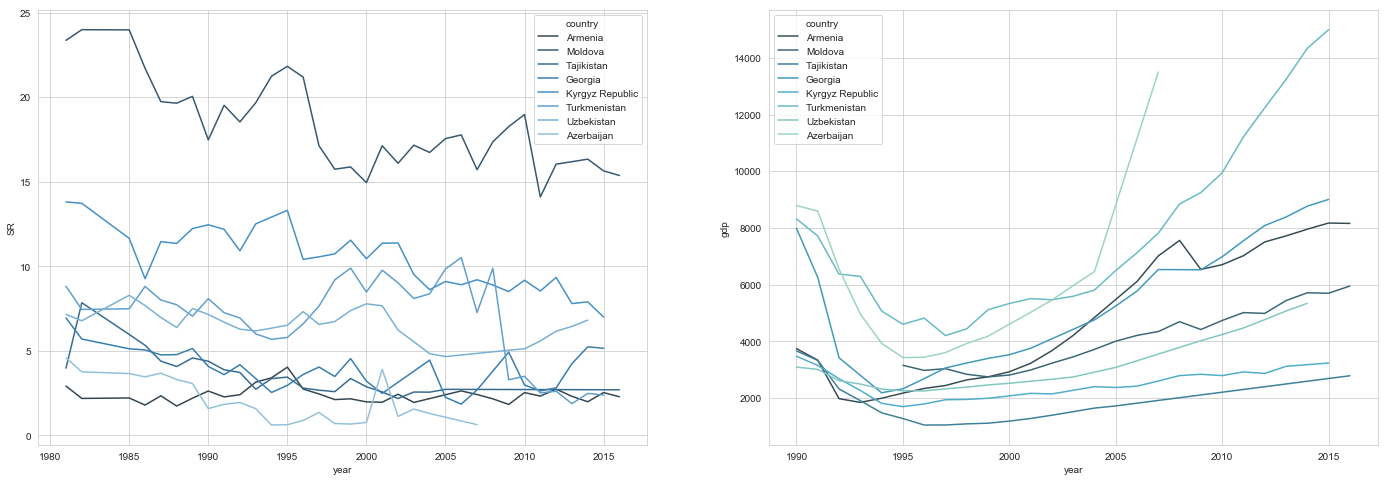

In [10]:
##### The USSR Cohort 2: Armenia, Azerbaijan, Georgia, Kyrgyz Republic, Moldova, Tajikistan, Turkmenistan, Uzbekistan 
f, axes=plt.subplots(1,2, figsize=(24,8))
sns.set_style('whitegrid')
sns.lineplot(data=USSR_dat2, x='year', y='SR', estimator=None, units='country', hue='country', palette=sns.color_palette('Blues_d', 8), ax=axes[0])
sns.lineplot(data=USSR_dat2, x='year', y='gdp', estimator=None, units='country', hue='country', palette=sns.color_palette('GnBu_d', 8), ax=axes[1])


 The relationship between suicide rates and GDP is quite different in the second USSR cohort where there is no
 dramatic increase or decrease between 1990 and 2015, and the suicide rates in general are lower than countries the first cohort.

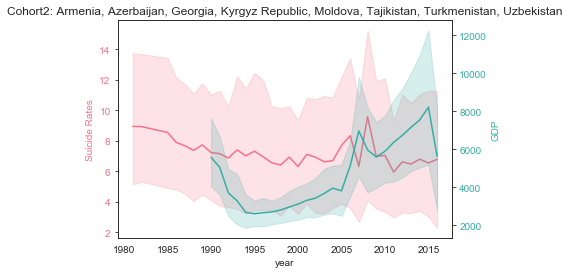

In [11]:
cols1=sns.color_palette("husl", 8)[0]
cols2=sns.color_palette("husl", 8)[4]
sns.set_style('white')
fig, ax1 = plt.subplots()
plt.title('Cohort2: Armenia, Azerbaijan, Georgia, Kyrgyz Republic, Moldova, Tajikistan, Turkmenistan, Uzbekistan')
sns.lineplot(data=USSR_dat2, x='year', y='SR', color=cols1)
ax1.set_ylabel('Suicide Rates', color=cols1)
ax1.tick_params(axis='y', labelcolor=cols1)
ax2 = plt.twinx()
sns.lineplot(data=USSR_dat2, x='year', y='gdp', ax=ax2, color=cols2)
ax2.set_ylabel('GDP', color=cols2)
ax2.tick_params(axis='y', labelcolor=cols2)


 To quantify the association between SR and GDP, we calculated the correlation of GDP and SR in those two cohorts and found strong,
 negative correlations in the first cohort. All but 2 countries (Belarus and Kazakhstan) have a correlation coefficient of -0.88 or smaller.
 Even for Belarus and Kazakhstan, the correlation coefficient is moderately strong.

 The correlations in the second cohort, however, are weaker and of mixed direction.

In [13]:
def corrmat(country):
    tmp=SR_country[SR_country['country']==country]
    corr1=round(tmp[(tmp['gdp'].isnull()==0) & (tmp['SR'].isnull()==0)][['gdp','SR']].corr().iloc[0,1],3)
    corr2=round(tmp[(tmp['Unemployment'].isnull()==0) & (tmp['SR'].isnull()==0)][['Unemployment','SR']].corr().iloc[0,1],3)
    corr3=round(tmp[(tmp['cpi'].isnull()==0) & (tmp['SR'].isnull()==0)][['cpi','SR']].corr().iloc[0,1],3)
    corr4=round(tmp[(tmp['gini'].isnull()==0) & (tmp['SR'].isnull()==0)][['gini','SR']].corr().iloc[0,1],3)
    #print(corr1, corr2, corr3)
    maxval=' '
    maxcorr=0
    if (abs(corr1)==1):
        corr1=0
    if (abs(corr2)==1):
        corr2=0
    if (abs(corr3)==1):
        corr3=0
    if (abs(corr4)==1):
        corr4=0
    if (math.isnan(corr1)==False): 
        maxcorr=abs(corr1)
        maxval='GDP'
    if (math.isnan(corr2)==False):
        maxcorr=max(maxcorr, abs(corr2))
        if (maxcorr==abs(corr2)):
            maxval='UEM'
    if (math.isnan(corr3)==False):
        maxcorr=max(maxcorr, abs(corr3))
        if (maxcorr==abs(corr3)):
            maxval='CPI'
    if (math.isnan(corr4)==False):
        maxcorr=max(maxcorr, abs(corr4))
        if (maxcorr==abs(corr4)):
            maxval='GINI'
    corr=[country, corr1, corr2, corr3, corr4, maxcorr, maxval]
    del tmp,corr1,corr2, corr3, corr4, maxval, maxcorr
    return(corr)

SR_corr_mat=[]
allcountry=list(set(SR_country['country']))
for country in allcountry:
    SR_corr_mat.append(corrmat(country))
SR_corr_mat=pd.DataFrame(SR_corr_mat, columns=['country','gdp','unemployment','cpi','gini', 'max', 'max_col'])
SR_corr_mat[SR_corr_mat['country'].isin(USSR1)][['country','gdp']]


,country,gdp
14,Lithuania,-0.948
18,Kazakhstan,-0.641
61,Latvia,-0.955
70,Estonia,-0.965
89,Russian Federation,-0.937
102,Belarus,-0.623
104,Ukraine,-0.878


 The correlations in the second cohort, however, are weaker and of mixed direction.

In [14]:
SR_corr_mat[SR_corr_mat['country'].isin(USSR2)][['country','gdp']]


,country,gdp
0,Moldova,-0.296
5,Kyrgyz Republic,-0.491
23,Azerbaijan,0.063
38,Tajikistan,0.650
39,Georgia,0.270
42,Turkmenistan,-0.759
53,Armenia,-0.331
94,Uzbekistan,-0.295


 What do the seven countries have in common that made them suffer the same wave of high suicide rates after the dissolution of the Soviet Union?
 What distinguishes them from the other eight countries? Is it because they are countries that are immediately adjacent, geographically,
 to Russia? Or perhaps these countries have  a higher percentage of ethnic Russian residents, resulting in dissolution being received as a bigger
 social blow to those residents? We don’t have answers to those questions: what we have learned, however, is there is no one economic index that
 works across the board for all nations: but that one economic index may show a stronger impact in a subset of countries than in others.

### 1997 Asia Finanical Crisis
#### Japan 1991-1999
Prior to the 1997 Asia Financial Crisis, a Japanese asset-price bubble collapsed in late 1991 and early 1992.
 We can see a small jump in Japan’s suicide rates, from 16.03 per 100k in 1991 to 16.82 in 1992. This, in turn,
 helps us put the impact of the 1997 Asian financial crisis in context. That dramatic year-on-year increase in suicide rates,
 from 18.64 in 1997 to 25.12 in 1998, dwarfs the previous increase in 1992. Among the three initially-chosen indicators,
 unemployment stands out -- and proves to be strongly associated with SR.

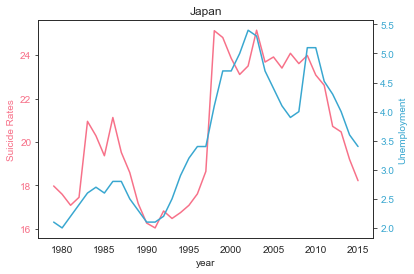

In [15]:
cols1=sns.color_palette("husl", 8)[0]
cols2=sns.color_palette("husl", 8)[5]
sns.set_style('white')
fig, ax1 = plt.subplots()
plt.title('Japan')
sns.lineplot(data=SR_country[SR_country['country']=='Japan'],  x='year', y='SR', color=cols1)
ax1.set_ylabel('Suicide Rates', color=cols1)
ax1.tick_params(axis='y', labelcolor=cols1)
ax2 = plt.twinx()
sns.lineplot(data=SR_country[SR_country['country']=='Japan'], x='year', y='Unemployment', ax=ax2, color=cols2)
ax2.set_ylabel('Unemployment', color=cols2)
ax2.tick_params(axis='y', labelcolor=cols2)


#### Hongkong 1997-2004
 Similarly to Japan, Hong Kong suffered a sharp economic contraction during the 1997 Asian financial crisis;
 correspondingly, we see an increase from 9.89 in 1997 to 12.94 in 1998. Here, too, the increase in SR
 is positively associated with unemployment rates.

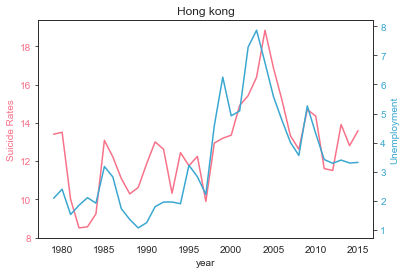

In [16]:
cols1=sns.color_palette("husl", 8)[0]
cols2=sns.color_palette("husl", 8)[5]
sns.set_style('white')
fig, ax1 = plt.subplots()
plt.title('Hong kong')
sns.lineplot(data=SR_country[SR_country['country']=='Hong Kong SAR, China'],  x='year', y='SR', color=cols1)
ax1.set_ylabel('Suicide Rates', color=cols1)
ax1.tick_params(axis='y', labelcolor=cols1)
ax2 = plt.twinx()
sns.lineplot(data=SR_country[SR_country['country']=='Hong Kong SAR, China'], x='year', y='Unemployment', ax=ax2, color=cols2)
ax2.set_ylabel('Unemployment', color=cols2)
ax2.tick_params(axis='y', labelcolor=cols2)


#### What about other countries?
 Intriguingly, the unemployment rate does not show a strong association with SR in other countries impacted by the financial crisis.
Korea

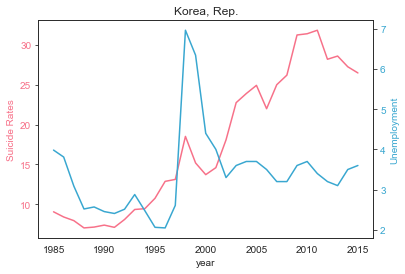

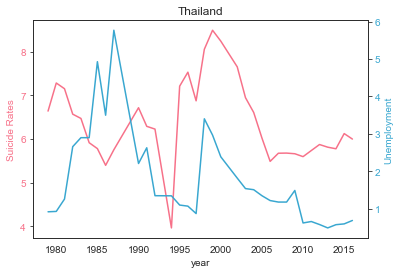

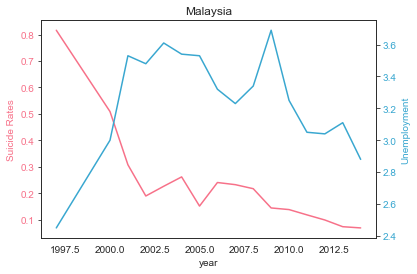

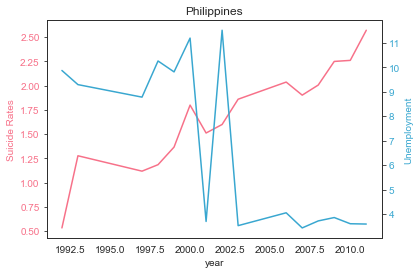

In [17]:
cols1=sns.color_palette("husl", 8)[0]
cols2=sns.color_palette("husl", 8)[5]
sns.set_style('white')
fig, ax1 = plt.subplots()
plt.title('Korea, Rep.')
sns.lineplot(data=SR_country[SR_country['country']=='Korea, Rep.'],  x='year', y='SR', color=cols1)
ax1.set_ylabel('Suicide Rates', color=cols1)
ax1.tick_params(axis='y', labelcolor=cols1)
ax2 = plt.twinx()
sns.lineplot(data=SR_country[SR_country['country']=='Korea, Rep.'], x='year', y='Unemployment', ax=ax2, color=cols2)
ax2.set_ylabel('Unemployment', color=cols2)
ax2.tick_params(axis='y', labelcolor=cols2)
#Thailand
cols1=sns.color_palette("husl", 8)[0]
cols2=sns.color_palette("husl", 8)[5]
sns.set_style('white')
fig, ax1 = plt.subplots()
plt.title('Thailand')
sns.lineplot(data=SR_country[SR_country['country']=='Thailand'],  x='year', y='SR', color=cols1)
ax1.set_ylabel('Suicide Rates', color=cols1)
ax1.tick_params(axis='y', labelcolor=cols1)
ax2 = plt.twinx()
sns.lineplot(data=SR_country[SR_country['country']=='Thailand'], x='year', y='Unemployment', ax=ax2, color=cols2)
ax2.set_ylabel('Unemployment', color=cols2)
ax2.tick_params(axis='y', labelcolor=cols2)
#Malaysia
cols1=sns.color_palette("husl", 8)[0]
cols2=sns.color_palette("husl", 8)[5]
sns.set_style('white')
fig, ax1 = plt.subplots()
plt.title('Malaysia')
sns.lineplot(data=SR_country[SR_country['country']=='Malaysia'],  x='year', y='SR', color=cols1)
ax1.set_ylabel('Suicide Rates', color=cols1)
ax1.tick_params(axis='y', labelcolor=cols1)
ax2 = plt.twinx()
sns.lineplot(data=SR_country[SR_country['country']=='Malaysia'], x='year', y='Unemployment', ax=ax2, color=cols2)
ax2.set_ylabel('Unemployment', color=cols2)
ax2.tick_params(axis='y', labelcolor=cols2)
#Philippines
cols1=sns.color_palette("husl", 8)[0]
cols2=sns.color_palette("husl", 8)[5]
sns.set_style('white')
fig, ax1 = plt.subplots()
plt.title('Philippines')
sns.lineplot(data=SR_country[SR_country['country']=='Philippines'],  x='year', y='SR', color=cols1)
ax1.set_ylabel('Suicide Rates', color=cols1)
ax1.tick_params(axis='y', labelcolor=cols1)
ax2 = plt.twinx()
sns.lineplot(data=SR_country[SR_country['country']=='Philippines'], x='year', y='Unemployment', ax=ax2, color=cols2)
ax2.set_ylabel('Unemployment', color=cols2)
ax2.tick_params(axis='y', labelcolor=cols2)


 Again, like the dissolution of Soviet Union, the financial crisis had a stronger impact on SR in some Asian countries than others.
 Unemployment rate associates with SR in Japan and Hong Kong during that crisis, but not in other countries.
 Crises are like a magnifying glass. By examining SR during political and economic crises,
 we were able to see how SR change with the economy in extreme cases.
 Despite participation in supranational blocs, a given nation’s SR does not always appear affected by such memberships.
 Other trans-national influences may be at play.

 If we cannot find the most efficient economic predictor for SR across
 the globe or regions, can we find the most efficient economic predictor for each country?
#### Finding the strongest economic predictor for SR in each country
 We used Pearson’s correlation coefficient to quantify the association between SR and GDP, Unemployment Rate,
 and Gini coefficient. Then, a maximum correlation coefficient is calculated to determine which economic
 statistic is the best predictor for SR in that country. The matrix below shows 80 countries whose max correlation
 coefficient between SR and economy is larger than 0.50.

In [18]:
SR_corr_mat=SR_corr_mat[SR_corr_mat['max']>0]
corr_gini=SR_corr_mat[SR_corr_mat['max_col']=='GINI'].reset_index()


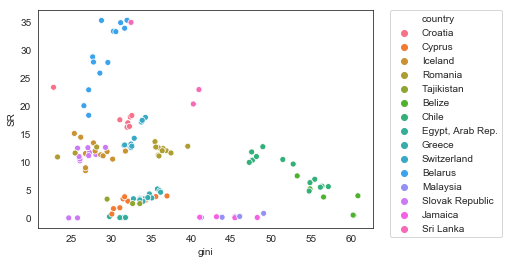

In [19]:
#f, axes=plt.subplots(1,15, figsize=(30,2), sharey=True)
sns.scatterplot(data=SR_country[SR_country['country'].isin(list(corr_gini['country']))], \
    x='gini', y='SR', hue='country')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)